In [ ]:
# %pip install pandas numpy scikit-learn opencv-python-headless matplotlib tqdm seaborn tensorflow

Initial shape of the dataset:  (10407, 4)
Reading images from /home/derrickle/Documents/RMIT/ML_Machine_Learning/Group_Project/Rice-Plant-Disease-Classification-/Dataset/train_images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/10407 [00:00<?, ?it/s]

  0%|          | 0/10407 [00:00<?, ?it/s]

Issue checks completed. 379 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


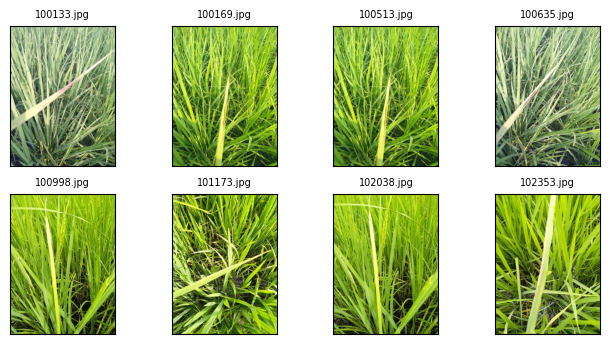

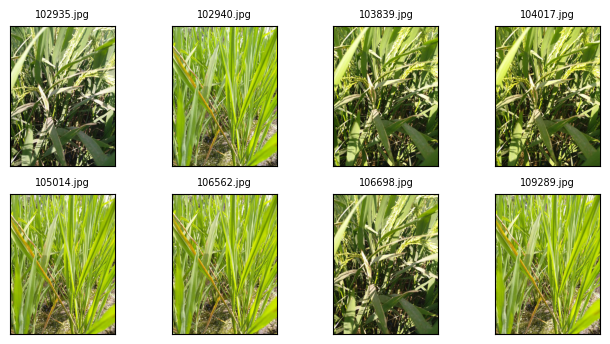

different metadata
different metadata
Final shape of the dataset:  (10206, 4)


In [3]:
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np
from cleanvision import Imagelab
from cv2.typing import MatLike

df = pd.read_csv("Dataset/meta_train.csv")

print("Initial shape of the dataset: ", df.shape)

imagelab = Imagelab(data_path="Dataset/train_images")
imagelab.find_issues()

imagelab.info["statistics"]["aspect_ratio"]

imagelab.info["statistics"]["size"]

imagelab.issue_summary

exact_duplicate = imagelab.issues[
    imagelab.issues["is_exact_duplicates_issue"]
].index.tolist()
near_duplicate = imagelab.issues[
    imagelab.issues["is_near_duplicates_issue"]
].index.tolist()
imagelab.visualize(image_files=exact_duplicate[:8])
imagelab.visualize(image_files=near_duplicate[:8])

unreliable_sets = []

for set in imagelab.info["exact_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["near_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["exact_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in imagelab.info["near_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in unreliable_sets:
    for i in range(len(set)):
        df = df[df["image_id"] != set[i].split("/")[-1]]
        
print("Final shape of the dataset: ", df.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# Encode labels as integers (for sparse_categorical_crossentropy)
from sklearn.preprocessing import LabelEncoder

df['label_encoded'] = LabelEncoder().fit_transform(df['label'])

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

print("Train shape: ", train_df.shape)
print("Validation shape: ", val_df.shape)


Train shape:  (8164, 5)
Validation shape:  (2042, 5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np

class PaddyImageSequence(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224,224), img_dir="Dataset/preprocessed_images", augment=False):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        images = []
        labels = []
        for _, row in batch.iterrows():
            img_path = f"{self.img_dir}/{row['label']}/{row['image_id']}"
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue  # Skip this image
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize
            if self.augment:
                if np.random.rand() < 0.5:
                    img = np.fliplr(img)
                if np.random.rand() < 0.5:
                    img = np.flipud(img)
            images.append(img)
            labels.append(row['label_encoded'])
        if not images:
            print(f"Warning: No valid images in batch {idx}. Returning dummy batch.")
            images = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
            labels = np.zeros((self.batch_size,), dtype=np.int32)
        return np.array(images), np.array(labels)



2025-05-09 18:04:34.392585: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 18:04:34.396324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 18:04:34.498685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 18:04:34.535834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746788674.606943  295746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746788674.62

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_cnn_model(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the model
num_classes = df['label_encoded'].nunique()
model = create_cnn_model(num_classes=num_classes)
model.summary()


/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-09 18:04:40.188658: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,238,218 (50.50 MB)

 Trainable params: 13,237,258 (50.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
batch_size = 32
train_gen = PaddyImageSequence(train_df, batch_size=batch_size, augment=True)
val_gen = PaddyImageSequence(val_df, batch_size=batch_size, augment=False)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation accuracy: {val_acc:.4f}")
